In [1]:
import pandas as pd
import zipfile
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import torch
import copy
import random
import torch.nn as nn
import torch.optim as optim
import shutil

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
from sklearn.utils import class_weight

from nltk.corpus import stopwords

from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms, datasets

from PIL import Image

sns.set_style('whitegrid')
sns.set_context('notebook')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data preparation

- unpack zip folder with the data
- retrieve labels from filenames and load images
- correct the invalid character in Albrecht Dürer's surname

In [ ]:
def prepare_data(folder_name, zip_name, size, mode=1, to_pickle=True):
    
    if not os.path.exists(folder_name):
        with zipfile.ZipFile(zip_name, 'r') as archive:
            for file in archive.namelist():
                if file.startswith('resized/') and file != 'resized/':
                    archive.extract(file)
                    
        os.rename('resized', folder_name)
            
    labels, paintings = [], []
    for filename in os.listdir(folder_name):
        path = os.path.join(folder_name, filename)

        if 'Albrecht_D' in filename:
            filename = filename.replace(filename.split('_')[1], 'Durer')
            new_path = os.path.join(folder_name, filename)
            os.rename(path, new_path)
            path = new_path

        labels.append(' '.join(filename.split('_')[:-1]))

        image = cv2.cvtColor(cv2.imread(path, mode), cv2.COLOR_BGR2RGB)
        paintings.append(cv2.resize(image, (size,size)))

    if to_pickle == True:
        with open('paintings', 'wb') as file:
            pickle.dump(paintings, file)
        with open('labels', 'wb') as file:
            pickle.dump(labels, file)
    
    return labels, paintings

In [ ]:
labels, paintings = prepare_data('images', 'resized.zip', size=96)

In [ ]:
paintings, labels = pickle.load(open('paintings','rb')), pickle.load(open('labels','rb'))

create directory structure required by pytorch

In [ ]:
def train_test_val_folders(folder, all_labels, size=0.1):
    files = os.listdir(folder)
    
    print('splitting...')
    X_train, X_test, y_train, y_test = train_test_split(files, all_labels, stratify=all_labels, test_size=size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=size, random_state=42)
    
    sets = [X_train, X_val, X_test]
    labels = [y_train, y_val, y_test]
    
    for i, set_name in enumerate(['train', 'val', 'test']):
        
        if not os.path.exists(set_name):
            os.makedirs(set_name)
            
            for j, filename in enumerate(sets[i]):
                inner_folder = os.path.join(set_name, labels[i][j])
                
                if not os.path.exists(inner_folder):
                    os.makedirs(inner_folder)
                    
                path = os.path.join(folder, filename)
                new_path = os.path.join(inner_folder, filename)
                shutil.copyfile(path, new_path)
    
    print('done, files are now in separate folders')

In [ ]:
train_test_val_folders('images', labels)

splitting...
done, files are now in separate folders


# eda

In [ ]:
df = pd.read_csv('artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


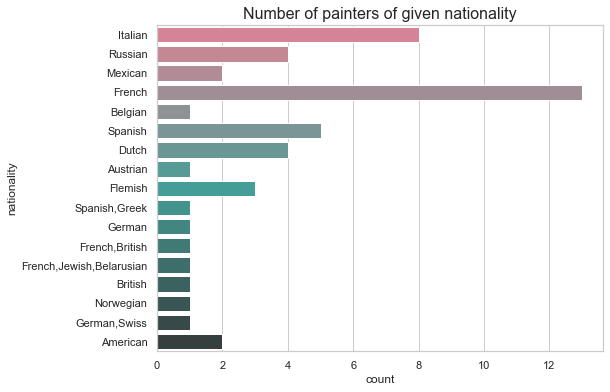

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, y='nationality', palette='husl_d');
plt.title('Number of painters of given nationality', fontsize=16);

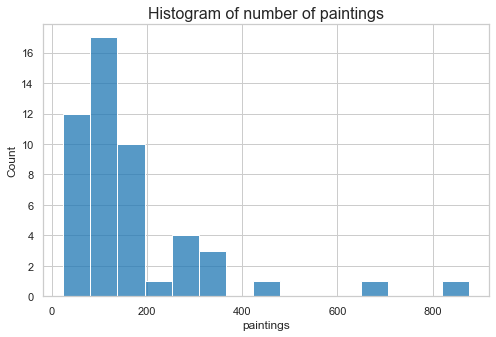

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='paintings');
plt.title('Histogram of number of paintings', fontsize=16);

In [ ]:
df[['name','paintings']].sort_values('paintings', ascending=False)[:10]

,name,paintings
8,Vincent van Gogh,877
30,Edgar Degas,702
13,Pablo Picasso,439
15,Pierre-Auguste Renoir,336
19,Albrecht Dürer,328
46,Paul Gauguin,311
16,Francisco Goya,291
31,Rembrandt,262
20,Alfred Sisley,259
32,Titian,255


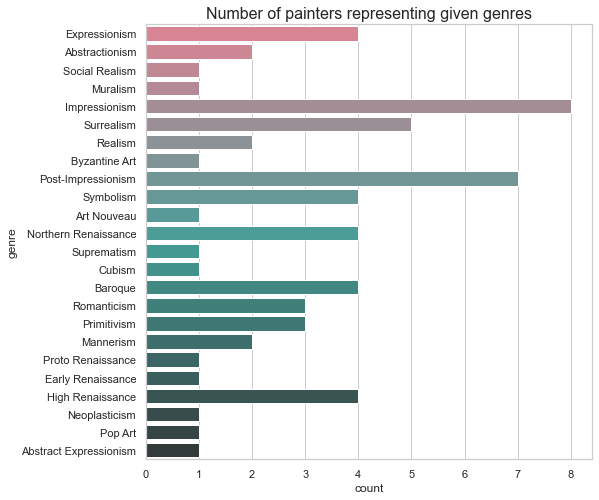

In [ ]:
genres = ','.join(list(df['genre'].values)).split(',')

plt.figure(figsize=(8,8))
sns.countplot(y=genres, palette='husl_d');
plt.ylabel('genre');
plt.title('Number of painters representing given genres', fontsize=16);

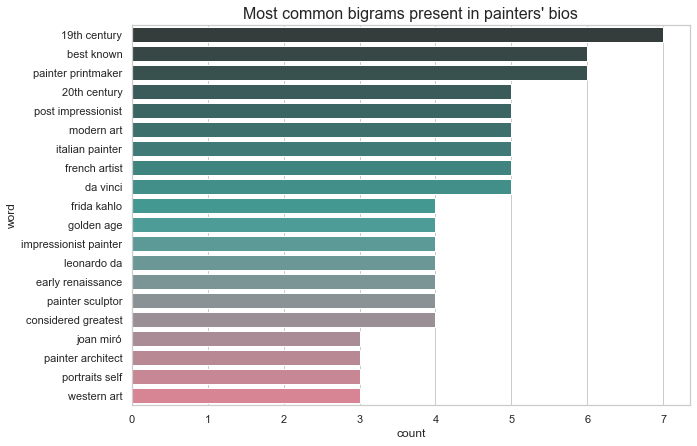

In [ ]:
#nltk.download('stopwords')
all_sw = list(sklear_stopwords) + stopwords.words('english')
count_vectorizer = CountVectorizer(stop_words = all_sw, max_features=20, ngram_range=(2,2))
fit = count_vectorizer.fit_transform(df['bio'])

counts = pd.DataFrame({'word':count_vectorizer.get_feature_names(), 'count':fit.sum(axis=0).tolist()[0]})
counts = counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,7))
sns.barplot(y=counts['word'], x=counts['count'], palette='husl_r_d');
plt.title("Most common bigrams present in painters' bios", fontsize=16);

some of the paintings

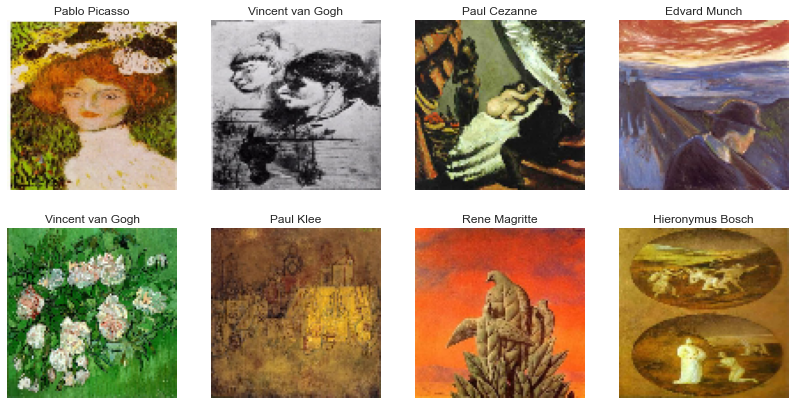

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(14,7))
axes = axes.flatten()
for i in range(8):
    k = random.randint(0, len(paintings))
    axes[i].imshow(paintings[k]);
    axes[i].axis('off');
    axes[i].set_title(labels[k]);

In [ ]:
size = 96

In [ ]:
rgb = np.array(paintings).reshape(-1,size,size,3).reshape(-1, 3)
unique_colours, counts = np.unique(rgb, return_counts=True, axis=0)
colours = pd.DataFrame({'colour':list(unique_colours), 'count':counts}).sort_values('count', ascending=False)

400 most/least frequent colors shown on a grid

In [ ]:
most_100 = colours[:400].copy()
least_100 = colours[-400:].copy()

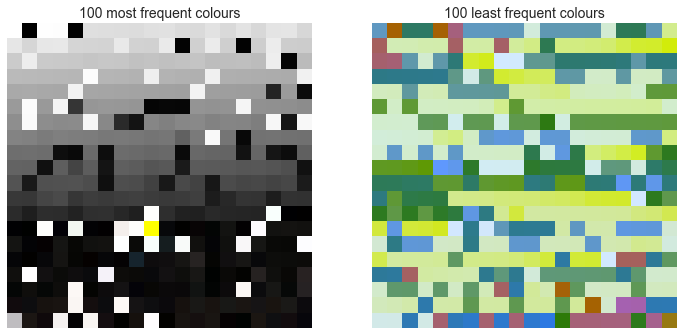

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
axes[0].imshow(np.stack(most_100['colour'].values, axis=0).reshape(20,20,3));
axes[1].imshow(np.stack(least_100['colour'].values, axis=0).reshape(20,20,3));
for i in [0,1]:
    axes[i].grid(False);
    axes[i].axis('off');
    which = 'most' if i == 0 else 'least'
    axes[i].set_title(fr'100 {which} frequent colours', fontsize=14)

this yellow tile in 100 most frequent colours is quite interesting

# classification

compute weights

In [8]:
labels = pickle.load(open('labels','rb'))
weights = class_weight.compute_class_weight('balanced', classes=sorted(list(set(labels))), y=labels)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
def pytorch_data_from_folder(path='', batch_size=16):
    vecs = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(vecs[0], vecs[1])]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(vecs[0], vecs[1])]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(vecs[0], vecs[1])])
    }
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(path,x), data_transforms[x])
                      for x in ['train', 'val', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
                   for x in ['train', 'val', 'test']}
    data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    
    return dataloaders, data_size

define training loop

In [32]:
def train_model(model, criterion, optimizer, scheduler, epochs, dataloaders, data_size):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(epochs):
        print('')
        print(fr'======== Epoch {epoch + 1} / {epochs} ========')
        print('Training...')
        t0 = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()
            
            dataloader = dataloaders[phase]
            running_loss = 0
            running_corrects = 0

            for step, batch in enumerate(dataloader):
                if step % 80 == 0 and not step == 0:
                    print(fr'Batch {step:>5,} of {len(dataloader):>5,}. Elapsed: {round(time.time()-t0, 2)} s.')

                inputs = batch[0].to(device)
                labels = batch[1].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
            
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/data_size[phase]
            epoch_accuracy = running_corrects.double()/data_size[phase]

            print(fr'== {phase} == loss: {epoch_loss:.4f} accuracy: {epoch_accuracy:.4f}')

            if phase == 'val' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

define model

In [2]:
class ResModel(nn.Module):
    def __init__(self, nclasses):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        self.network.fc = nn.Linear(self.network.fc.in_features, nclasses)
        
    def forward(self, x):
        return self.network(x)

In [13]:
dataloaders, data_size = pytorch_data_from_folder(path='/content/drive/My Drive/paintings_data')

In [30]:
model = ResModel(50).to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
best_model = train_model(model, criterion, optimizer, scheduler, 10, dataloaders, data_size)


======== Epoch 1 / 10 ========
Training...
Batch    80 of   423. Elapsed: 15.22 s.
Batch   160 of   423. Elapsed: 30.3 s.
Batch   240 of   423. Elapsed: 45.32 s.
Batch   320 of   423. Elapsed: 60.06 s.
Batch   400 of   423. Elapsed: 74.85 s.
== train == loss: 2.2689 accuracy: 0.3807
== val == loss: 1.5329 accuracy: 0.5399

======== Epoch 2 / 10 ========
Training...
Batch    80 of   423. Elapsed: 15.73 s.
Batch   160 of   423. Elapsed: 30.75 s.
Batch   240 of   423. Elapsed: 45.69 s.
Batch   320 of   423. Elapsed: 60.54 s.
Batch   400 of   423. Elapsed: 75.67 s.
== train == loss: 1.5353 accuracy: 0.5389
== val == loss: 1.1897 accuracy: 0.6356

======== Epoch 3 / 10 ========
Training...
Batch    80 of   423. Elapsed: 15.19 s.
Batch   160 of   423. Elapsed: 29.99 s.
Batch   240 of   423. Elapsed: 45.04 s.
Batch   320 of   423. Elapsed: 60.56 s.
Batch   400 of   423. Elapsed: 75.36 s.
== train == loss: 1.2859 accuracy: 0.5932
== val == loss: 1.0423 accuracy: 0.6782

======== Epoch 4 / 10 

In [34]:
torch.save(model.state_dict(), 'model_resnet50_80.pth')

# prediction

trying out prediction for a single image

In [4]:
model = ResModel(50)
model.load_state_dict(torch.load('model_resnet50_80.pth', map_location=torch.device('cpu')))
model.eval()

ResModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [5]:
test_images, test_labels = [], []
for folder in os.listdir('test'):
    folder_path = os.path.join('test', folder)
    for filename in os.listdir(folder_path):
        test_images.append(os.path.join(folder_path, filename))
        test_labels.append(folder)

In [6]:
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

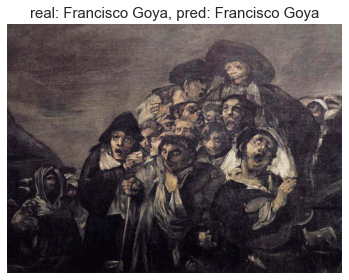

In [14]:
which = random.choice(np.arange(len(test_images)))
with torch.no_grad():
    image_raw = Image.open(test_images[which]).convert('RGB')
    image = transformation(image_raw)
    pred = np.argmax(model(image.view(1, 3, 224, 224)))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(image_raw);
    ax.axis('off');
    ax.set_title(fr'real: {np.unique(labels)[pred]}, pred: {test_labels[which]}', fontsize=15);